# Conditional Diffusion Model

**PHABEL ANTONIO LÓPEZ DELGADO.**

En este cuaderno se ilustra una forma de añadir información de condicionamiento a un modelo de difusión. Específicamente, se entrenará un modelo de difusión condicionado por clase utilizando el conjunto de datos Fashion_MNIST pero ahora permitiendo especificar qué dígito queremos que el modelo genere en la etapa de inferencia

#### Arquitectura del Condicionamiento:

- Embedding de clase: Mapeo aprendido de etiquetas categóricas a vectores densos
- Concatenación espacial: Expansión del embedding a dimensiones de imagen
- UNet modificada: Arquitectura con canales de entrada adicionales para condicionamiento
- Entrenamiento conjunto: Optimización simultánea de generación y condicionamiento

#### Flujo de Procesamiento:

1. Etiqueta de clase → Embedding aprendido → Expansión espacial
2. Imagen ruidosa + Condicionamiento → Concatenación por canales
3. Entrada combinada → UNet → Predicción de ruido
4. Pérdida MSE entre ruido real y predicho → Actualización de parámetros

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


A continuación se descarga el conjunto de datos MNIST (imágenes de dígitos manuscritos del 0 al 9), se carga en un DataLoader para facilitar el manejo por lotes, y se visualizan algunos ejemplos.

 - `x` contiene imágenes con forma (batch, 1, 28, 28), donde cada imagen es en escala de grises de 28x28 píxeles.

 - `y` contiene las etiquetas correspondientes a cada imagen.

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 1, 6, 7, 1, 5, 7, 7])


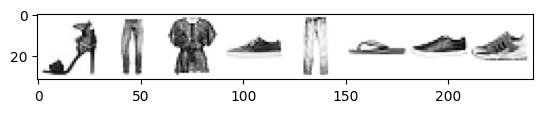

In [ ]:
dataset = torchvision.datasets.FashionMNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## 1. Creación de una U-Net condicionada por clase

La forma en la que se introduce el condicionamiento por clase es la siguiente:

 - Se crea un modelo estándar `UNet2DModel` pero añadiendo canales de entrada adicionales.

 - Se mapea la etiqueta de clase a un vector aprendido de tamaño `(class_emb_size)` usando una capa de embedding.

 - Esta información se concatena como canales extra en la entrada interna de la UNet, usando `net_input = torch.cat((x, class_cond), 1)`.

    Finalmente, esta entrada `(net_input)`, que ahora tiene `(class_emb_size+1)` canales en total, se alimenta al modelo UNet para obtener la predicción.

En este ejemplo, el tamaño del embedding de clase (`class_emb_size`) es 4, pero este valor es arbitrario. Puedes experimentar usando tamaño 1 (para ver si aún funciona), tamaño 10 (para que coincida con el número de clases), o incluso reemplazar la capa de embedding aprendida por un simple codificado one-hot de la clase.

La documentación de la U-net que utilizaremos la puedes consultar en la siguiente liga: https://huggingface.co/docs/diffusers/api/models/unet2d

In [ ]:
class ClassConditionedUnet(nn.Module):
    """
    Red U-Net condicionada por clase para modelos de difusión.

    Esta arquitectura extiende una U-Net estándar para incorporar información de clase
    mediante embeddings aprendidos que se concatenan espacialmente con la entrada de imagen.

    Parámetros:
    -----------
    num_classes : int, opcional (por defecto=10)
        Número total de clases en el conjunto de datos. Para MNIST son 10 dígitos (0-9).

    class_emb_size : int, opcional (por defecto=4)
        Dimensionalidad del vector de embedding para cada clase. Controla la capacidad
        representacional del condicionamiento de clase.
    """

    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # La capa de embedding mapea la etiqueta de clase a un vector de tamaño class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # self.model es una UNet no condicionada con canales de entrada adicionales
        # para aceptar la información de condicionamiento (el embedding de clase)
        self.model = UNet2DModel(
            sample_size=28,                    # resolución objetivo de la imagen
            in_channels=1 + class_emb_size,    # canales adicionales para condicionamiento de clase
            out_channels=1,                    # número de canales de salida
            layers_per_block=2,                # capas ResNet por bloque UNet
            block_out_channels=(32, 64, 64),   # canales de salida por bloque
            down_block_types=(
                "DownBlock2D",        # bloque ResNet de downsampling regular
                "AttnDownBlock2D",    # bloque ResNet con auto-atención espacial
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # bloque ResNet de upsampling con auto-atención espacial
                "UpBlock2D",          # bloque ResNet de upsampling regular
            ),
        )

    def forward(self, x, t, class_labels):
        """
        Propagación hacia adelante de la U-Net condicionada por clase.

        Parámetros:
        -----------
        x : torch.Tensor
            Imágenes ruidosas de entrada con forma (batch_size, 1, 28, 28).

        t : torch.Tensor
            Pasos temporales del proceso de difusión con forma (batch_size,).

        class_labels : torch.Tensor
            Etiquetas de clase para condicionamiento con forma (batch_size,).
            Valores enteros en el rango [0, num_classes-1].

        Retorna:
        --------
        torch.Tensor
            Predicción de ruido con forma (batch_size, 1, 28, 28).
        """
        # Forma de x: (batch_size, canales, ancho, alto)
        bs, ch, w, h = x.shape

        # Condicionamiento de clase en forma correcta para añadir como canales de entrada adicionales
        class_cond = self.class_emb(class_labels)  # Mapeo a dimensión de embedding
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x tiene forma (bs, 1, 28, 28) y class_cond ahora es (bs, 4, 28, 28)

        # La entrada de red es ahora x y class_cond concatenados a lo largo de la dimensión 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, 5, 28, 28)

        # Alimentar esto a la UNet junto con el paso temporal y retornar la predicción
        return self.model(net_input, t).sample  # (bs, 1, 28, 28)

## 2. Entrenamiento

Documentación de la clase DDPM: [https://huggingface.co/docs/diffusers/api/schedulers/ddpm].

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
n_epochs = 5
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

Iniciando entrenamiento del modelo de difusión condicionado por clase...
Configuración: 5 épocas, lote de 128, dispositivo cuda


  0%|          | 0/469 [00:00<?, ?it/s]

Época 1 completada. Pérdida promedio de la época: 0.08857, Promedio de los últimos 100 valores: 0.08857


  0%|          | 0/469 [00:00<?, ?it/s]

Época 2 completada. Pérdida promedio de la época: 0.07818, Promedio de los últimos 100 valores: 0.07818


  0%|          | 0/469 [00:00<?, ?it/s]

Época 3 completada. Pérdida promedio de la época: 0.07528, Promedio de los últimos 100 valores: 0.07528


  0%|          | 0/469 [00:00<?, ?it/s]

Época 4 completada. Pérdida promedio de la época: 0.07339, Promedio de los últimos 100 valores: 0.07339


  0%|          | 0/469 [00:00<?, ?it/s]

Época 5 completada. Pérdida promedio de la época: 0.07216, Promedio de los últimos 100 valores: 0.07216


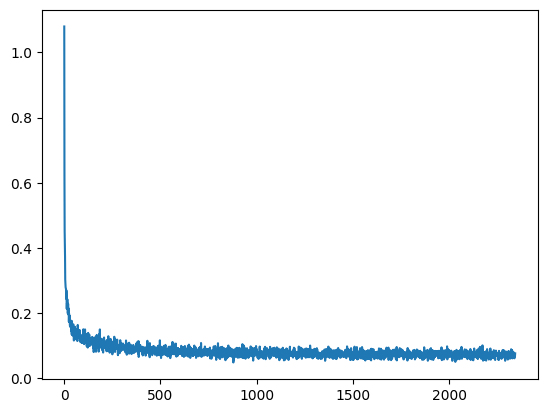

In [ ]:
losses = []

print("Iniciando entrenamiento del modelo de difusión condicionado por clase...")
print(f"Configuración: {n_epochs} épocas, lote de {train_dataloader.batch_size}, dispositivo {device}")

for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        x = x.to(device) * 2 - 1 # Normalizacion a [-1,1]
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps, y)
        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/100
    print(f'Época {epoch+1} completada. Pérdida promedio de la época: {avg_loss:.5f}, '
          f'Promedio de los últimos 100 valores: {avg_loss:.5f}')

plt.plot(losses)

### 3. Muestreo

Generando muestras condicionadas por clase...
Generando 80 imágenes: Fashion MNIST
Etiquetas de condicionamiento: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4
 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 9 9
 9 9 9 9 9 9]


Proceso de muestreo:   0%|          | 0/1000 [00:00<?, ?it/s]

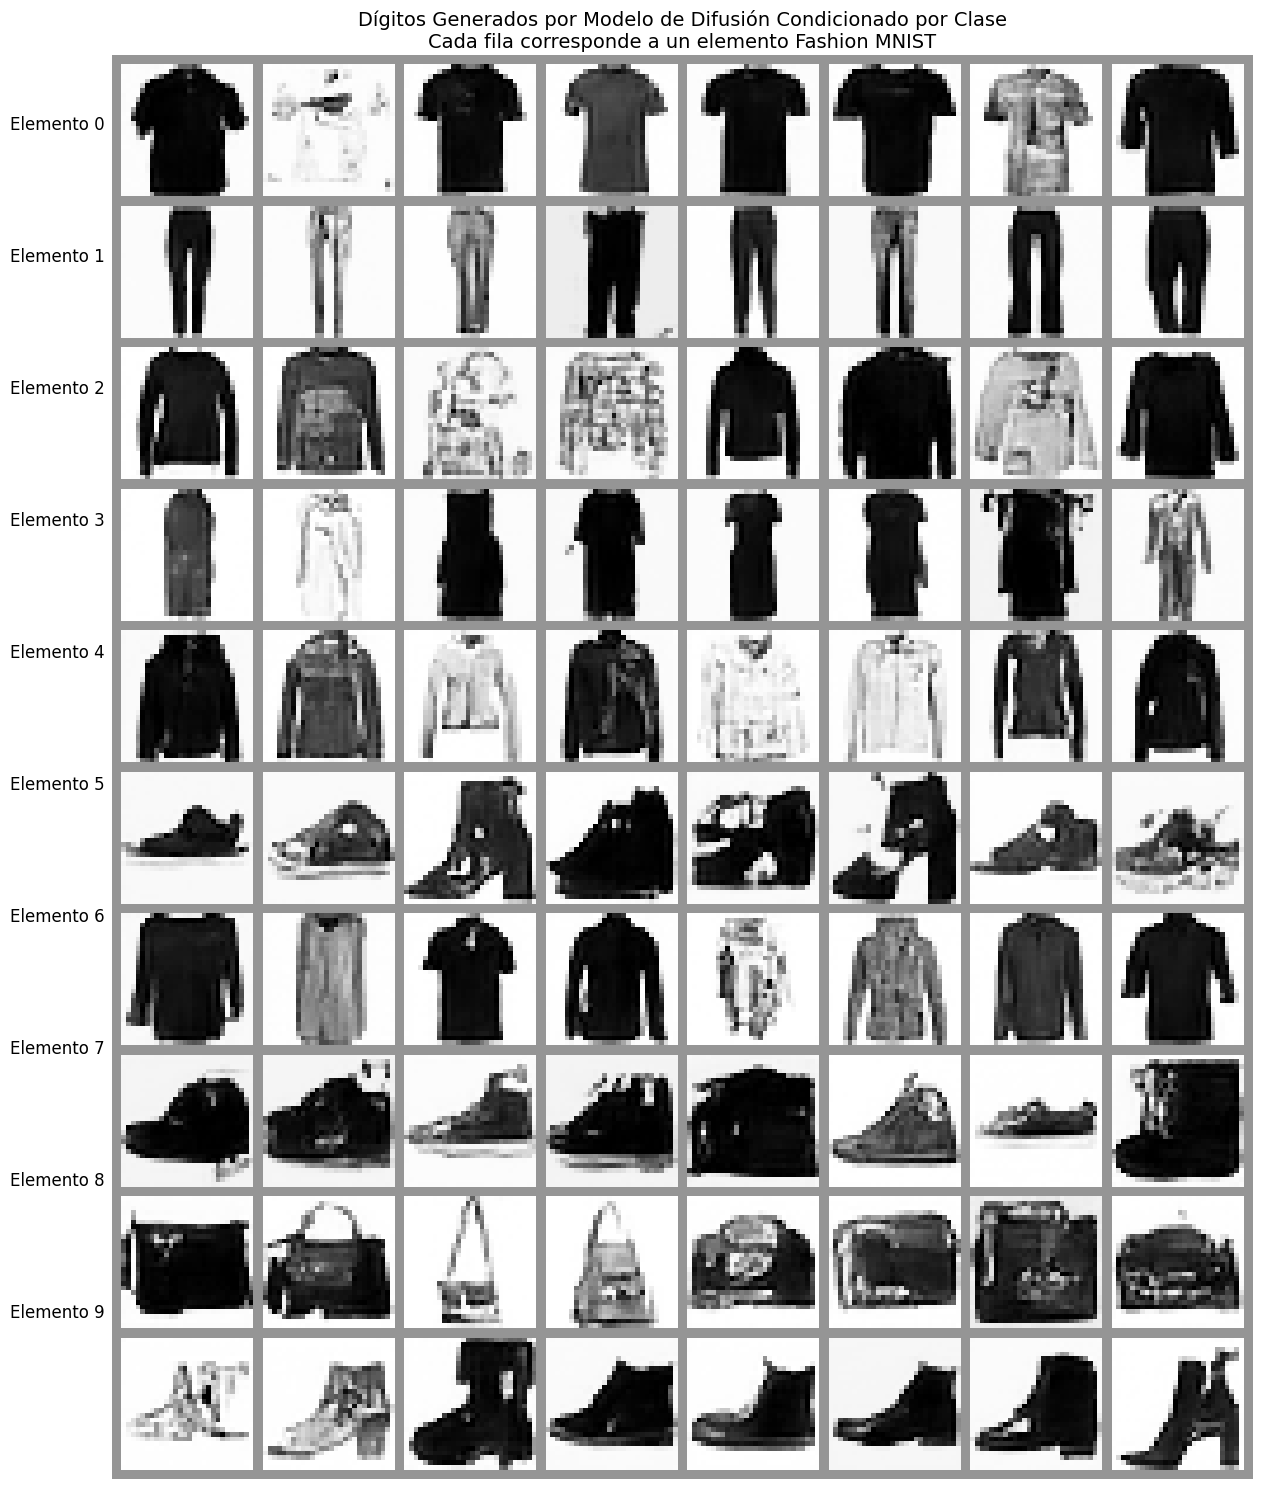

In [ ]:
print("Generando muestras condicionadas por clase...")

x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

print(f"Generando {len(x)} imágenes: Fashion MNIST")
print("Etiquetas de condicionamiento:", y.cpu().numpy())

for i, t in tqdm(enumerate(noise_scheduler.timesteps), desc="Proceso de muestreo", total=len(noise_scheduler.timesteps)):

    with torch.no_grad():
        residual = net(x, t, y)

    x = noise_scheduler.step(residual, t, x).prev_sample

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
grid_img = torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0]
ax.imshow(grid_img, cmap='Greys')
ax.set_title('Dígitos Generados por Modelo de Difusión Condicionado por Clase\n'
             'Cada fila corresponde a un elemento Fashion MNIST', fontsize=14)
ax.axis('off')

for i in range(10):
    ax.text(-2, 28*i + 14, f'Elemento {i}', fontsize=12, ha='right', va='center')

plt.tight_layout()
plt.show()

# Creación del Modelo DDPM

El Modelo de Difusión Probabilística para Eliminación de Ruido (Denoising Diffusion Probabilistic Model, DDPM) está basado en el trabajo seminal de Ho et al. (2020). Los modelos de difusión constituyen una clase de modelos generativos que aprenden a generar datos mediante la reversión gradual de un proceso de difusión que corrompe progresivamente los datos con ruido gaussiano.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from keras.datasets.fashion_mnist import load_data

import matplotlib.pyplot as plt
import numpy as np

from UNET_CODE import UNet

In [ ]:
(trainX, trainy), (testX, testy) = load_data()
trainX = np.float32(trainX) / 255.
testX = np.float32(testX) / 255.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def sample_batch(batch_size, device):
    """
    Función para muestrear un bloque de imágenes del conjunto de entrenamiento.

    Esta función selecciona aleatoriamente un subconjunto de imágenes del conjunto
    de entrenamiento MNIST, las normaliza y las redimensiona para su uso en el modelo.

    Parámetros:
    -----------
    batch_size : int
        Número de imágenes a incluir en el lote
    device : str
        Dispositivo de cómputo ('cuda' o 'cpu')

    Retorna:
    --------
    torch.Tensor
        Tensor de imágenes redimensionadas a 32x32 píxeles con dimensiones
        [batch_size, 1, 32, 32]

    Notas técnicas:
    ---------------
    - Las imágenes MNIST originales son de 28x28 píxeles
    - Se redimensionan a 32x32 mediante interpolación bilineal
    - Se añade una dimensión de canal (1 para escala de grises)
    - La normalización a [0,1] facilita el entrenamiento del modelo
    """

    indices = torch.randperm(trainX.shape[0])[:batch_size]
    data = torch.from_numpy(trainX[indices]).unsqueeze(1).to(device)
    return torch.nn.functional.interpolate(data, 32)

## 1. Fundamentos teóricos

**1. Proceso Directo (Forward Process)**
El proceso directo se define como una cadena de Markov que añade ruido gaussiano
gradualmente a los datos originales:

$$q(x_{1:T} | x_0) = \prod_{t=1}^T q(x_t | x_{t-1})$$

donde $q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t \mathbf{I})$

**2. Proceso Inverso (Reverse Process)**
El proceso inverso aprende a eliminar el ruido mediante una red neuronal.

**3. Función de Pérdida para Entrenamiento**
La función objetivo se deriva de la maximización de la verosimilitud:

$$\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$$

Esta formulación permite entrenar el modelo prediciendo el ruido añadido en cada paso.

In [ ]:
class DiffusionModel():
    """
    Implementación de un Modelo de Difusión Probabilística para Eliminación de Ruido.

    Esta clase encapsula la funcionalidad completa de un DDPM, incluyendo:
    - Definición de la programación de adición de ruido (noise schedules)
    - Algoritmo de entrenamiento
    - Algoritmo de muestreo/generación

    Atributos:
    ----------
    T : int
        Número total de pasos de difusión
    function_approximator : nn.Module
        Red neuronal que aproxima la función de eliminación de ruido
    device : str
        Dispositivo de cómputo ('cuda' o 'cpu')
    beta : torch.Tensor
        Varianzas programadas para el proceso directo
    alpha : torch.Tensor
        Coeficientes derivados: α_t = 1 - β_t
    alpha_bar : torch.Tensor
        Productos acumulativos: ᾱ_t = ∏_{s=1}^t α_s
    """

    def __init__(self, T : int, model : nn.Module, device : str):
        """
        Inicializa el modelo de difusión con los parámetros especificados.

        Parámetros:
        -----------
        T : int
            Número de pasos de difusión (típicamente 1000)
        model : nn.Module
            Arquitectura de red neuronal (ej. U-Net)
        device : str
            Dispositivo de cómputo ('cuda' o 'cpu')
        """
        self.T = T
        self.function_approximator = model.to(device)
        self.device = device

        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def training(self, batch_size, optimizer):
        """
        Ejecuta un paso de entrenamiento del modelo de difusión.

        Implementa el Algoritmo 1 del paper original:
        1. Muestrea x_0 del conjunto de datos
        2. Muestrea t uniformemente de {1, ..., T}
        3. Muestrea ε ~ N(0, I)
        4. Calcula la pérdida ||ε - ε_θ(√ᾱ_t x_0 + √(1-ᾱ_t) ε, t)||²
        5. Actualiza los parámetros θ mediante descenso de gradiente

        Parámetros:
        -----------
        batch_size : int
            Tamaño del lote para entrenamiento
        optimizer : torch.optim.Optimizer
            Optimizador para actualizar los parámetros del modelo

        Retorna:
        --------
        float
            Valor de la función de pérdida para el lote actual
        """

        x0 = sample_batch(batch_size, self.device)

        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device, dtype=torch.long)

        eps = torch.randn_like(x0)


        alpha_bar_t = self.alpha_bar[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps
        eps_predicted = self.function_approximator(x_t, t-1)
        loss = nn.functional.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), use_tqdm=True):
        """
        Genera nuevas muestras mediante el proceso de difusión inverso.

        Implementa el Algoritmo 2 del paper original:
        1. Inicializa x_T ~ N(0, I)
        2. Para t = T, T-1, ..., 1:
           - Calcula μ_θ(x_t, t) usando la red neuronal
           - Muestrea x_{t-1} ~ N(μ_θ(x_t, t), σ_t² I)
        3. Retorna x_0

        Parámetros:
        -----------
        n_samples : int, opcional
            Número de muestras a generar (por defecto: 1)
        image_channels : int, opcional
            Número de canales de la imagen (por defecto: 1 para escala de grises)
        img_size : tuple, opcional
            Dimensiones de la imagen (por defecto: (32, 32))
        use_tqdm : bool, opcional
            Si mostrar barra de progreso (por defecto: True)

        Retorna:
        --------
        torch.Tensor
            Tensor con las muestras generadas de dimensiones
            [n_samples, image_channels, img_size[0], img_size[1]]
        """
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                         device=self.device)

        progress_bar = tqdm if use_tqdm else lambda x : x
        for t in progress_bar(range(self.T, 0, -1)):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)

            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            beta_t = self.beta[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t-1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z

        return x


## Hiperparámetros

A continuación se definen los hiperparámetros con los que entrenaremos el modelo de difusión. La red neuronal a utilizar se encuentra en un script auxiliar a este cuaderno y tiene una arquitectura de tipo U-net. Como revisamos antes, esta U-net incorpora una codificación del paso de adición de ruido *t*, lo cual facilita la implementación de este modelo. También definiremos 100 pasos de difusión en una primera etapa.

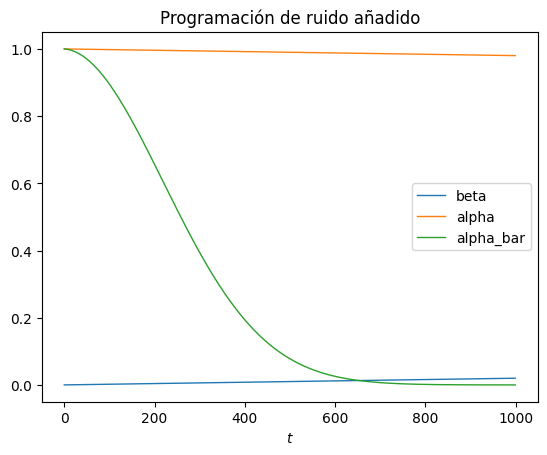

In [ ]:
device = 'cuda'
batch_size = 64
model = UNet()
pasos = 1000
epochs = 2000 #40000

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(pasos, model, device)

betas = np.linspace(1e-4, 0.02, pasos)
alphas = 1. - betas
alphas_bar = np.cumprod(alphas)

plt.figure()
plt.title('Programación de ruido añadido')
plt.plot(np.arange(betas.shape[0]), betas, linewidth=1, label='beta')
plt.plot(np.arange(betas.shape[0]), alphas, linewidth=1, label='alpha')
plt.plot(np.arange(betas.shape[0]), alphas_bar, linewidth=1, label='alpha_bar')
plt.xlabel('$t$')
plt.legend(loc='best')
plt.show()

## 3. Entrenamiento del modelo

El entrenamiento se realiza durante 40,000 épocas con las siguientes
características de monitoreo y evaluación:

1. **Registro de pérdida**: Se almacena la pérdida de cada época para
   análisis de convergencia
   
2. **Visualización periódica**: Cada 1000 épocas se generan gráficas de
   la función de pérdida.
   
3. **Evaluación cualitativa**: Cada 1000 épocas se generan 81 muestras
   para evaluación visual de la calidad generativa
   
4. **Guardado de checkpoints**: El modelo se guarda periódicamente para
   prevenir pérdida de progreso y permitir análisis posteriores

Este protocolo permite monitorear tanto la convergencia numérica como
la calidad perceptual de las muestras generadas.

In [ ]:
training_loss = []
for epoch in tqdm(range(epochs)):
    loss = diffusion_model.training(batch_size, optimizer)
    training_loss.append(loss)

    if epoch % 1000 == 0:
        plt.plot(training_loss)
        plt.savefig(f'training_loss_{epoch}.png')
        plt.close()

    if epoch % 1000 == 0:
        nb_images=81
        samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
        plt.figure(figsize=(17, 17))
        for i in range(nb_images):
            plt.subplot(9, 9, 1 + i)
            plt.axis('off')
            plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(), cmap='gray')
        plt.savefig(f'samples_epoch_{epoch}.png')
        plt.close()

        torch.save(model.cpu(), f'ddpm_epoch_{epoch}')
        model.cuda()

100%|██████████| 2000/2000 [24:27<00:00,  1.36it/s]


## 4. Generación de Muestras Aleatorias

In [ ]:
nb_images=10
samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
plt.figure(figsize=(17, 17))
for i in range(nb_images):
    plt.subplot(9, 9, 1 + i)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(), cmap='gray')
plt.savefig(f'samples_epoch_{epoch}.png')
plt.close()

torch.save(model.cpu(), f'ddpm_epoch_{epoch}')

## Preguntas

### 1. Explicar la diferencia en datos de entrada de el modelo DDPM y el de difusión condicional (2 pts).

La diferencia fundamental radica en la información de entrada que cada modelo utiliza: el DDPM base opera exclusivamente con la imagen ruidosa x_t y el timestep t, recibiendo entrada de dimensiones (batch_size, 1, 32, 32) y generando contenido de forma no controlada siguiendo la distribución aprendida. En contraste, el modelo condicionado incorpora información de clase mediante un mecanismo de concatenación espacial donde las etiquetas se transforman en embeddings aprendidos de dimensión class_emb_size (típicamente 4) que se expanden espacialmente y concatenan con la imagen: torch.cat((x, class_cond), 1), resultando en entrada de (batch_size, 1 + class_emb_size, 28, 28). Esta arquitectura permite que cada píxel "vea" la información de condicionamiento durante todo el procesamiento, habilitando control directo sobre el tipo de contenido generado, mientras que el DDPM base solo puede explorar estocásticamente el espacio latente aprendido sin dirección específica.

### 2. Explicar en términos generales la arquitectura de la red neuronal que elimina el ruido en el modelo de difusión (2 pts).

La arquitectura empleada es una U-Net adaptada para eliminación de ruido, caracterizada por una estructura encoder-decoder simétrica con skip connections que preservan información detallada a múltiples escalas de resolución. El encoder utiliza bloques DownBlock2D y AttnDownBlock2D que progresivamente reducen la resolución espacial mientras aumentan la profundidad de características, donde los bloques de atención permiten capturar dependencias espaciales de largo alcance cruciales para la estructura global de la imagen. El decoder emplea AttnUpBlock2D y UpBlock2D que realizan el proceso inverso de upsampling, mientras que las skip connections concatenan características correspondientes entre encoder y decoder, evitando la pérdida de detalles finos durante la compresión en el bottleneck. Un aspecto crítico es la codificación temporal del timestep t mediante embeddings posicionales que se inyectan en múltiples puntos de la arquitectura, permitiendo que el modelo comprenda qué nivel específico de ruido debe eliminar en cada paso, y en el caso condicionado, la información de clase también se propaga a través de toda la red para influir en el proceso de denoising a todas las escalas.

### 3. Explicar la función de pérdida utilizada para el entrenamiento de los modelos de difusión (2 pt).
La función de pérdida empleada en los modelos de difusión surge de una elegante reformulación del problema de maximización de verosimilitud, donde en lugar de predecir directamente la imagen denoised, el modelo aprende a predecir el ruido gaussiano que fue añadido en cada paso del proceso de corrupción. La formulación matemática es L = E[t,x₀,ε] [||ε - εθ(xₜ, t)||²], donde εθ representa la predicción de ruido de la red neuronal, ε es el ruido real añadido, y xₜ = √ᾱₜ x₀ + √(1-ᾱₜ) ε es la imagen ruidosa en el timestep t. Esta función de pérdida MSE simple pero poderosa permite que el modelo aprenda simultáneamente a eliminar diferentes niveles de ruido a través de todos los timesteps (muestreados uniformemente durante el entrenamiento), transformando el complejo problema de modelado de distribuciones condicionales en una tarea de regresión tratable que estabiliza el entrenamiento, reduce la varianza en las predicciones, y permite un muestreo eficiente durante la generación al aprender implícitamente la estructura completa de la distribución de datos.


### 4. Presentar las gráficas de la programación de los hiperparámetros α, β y  (2 pts)
Se muestra en el propio código, en el apartado "Hiperparámetros"

La programación de hiperparámetros constituye el núcleo del proceso de difusión, donde β_t controla la varianza de ruido añadido en cada paso mediante una progresión lineal desde β_start = 1e-4 hasta β_end = 0.02, asegurando una corrupción/destrucción gradual que comience con adiciones imperceptibles y progrese hacia ruido substancial; α_t = 1 - β_t representa el factor de conservación de señal original, decreciendo desde ~0.9999 hasta ~0.98; y ᾱₜ = ∏ₛ₌₁ᵗ αₛ es el producto acumulativo que controla la cantidad total de señal original persistente después de t pasos, exhibiendo una decaída exponencial desde 1.0 hasta valores cercanos a 0. Esta parametrización permite la fórmula de muestreo directo xₜ = √ᾱₜ x₀ + √(1-ᾱₜ) ε, donde la relación señal-ruido está completamente determinada por ᾱₜ: cuando ᾱₜ ≈ 1 (pasos iniciales) domina la señal original, cuando ᾱₜ ≈ 0 (pasos finales) domina el ruido gaussiano, creando una transición controlada que permite al modelo aprender efectivamente el mapeo inverso desde ruido puro hasta datos estructurados mediante un gradiente de dificultad creciente y manejable.

### 5. Generar cinco imágenes con los modelos entrenados. (2 pts)

Para generar cinco imágenes, el DDPM base inicializa ruido gaussiano puro x_T ~ N(0, I) con dimensiones (5, 1, 32, 32) y procede iterativamente desde t = 1000 hasta t = 1 aplicando la fórmula x_{t-1} = μθ(x_t, t) + σₜ × z, donde μθ = (1/√αₜ) × [x_t - (βₜ/√(1-ᾱₜ)) × εθ(x_t, t)] y z es ruido adicional para mantener estocasticidad, produciendo cinco dígitos Fashion_MNIST diversos sin control específico sobre el contenido. El modelo condicionado sigue un proceso similar pero con dimensiones (5, 1, 28, 28) y etiquetas específicas class_labels = [0, 1, 2, 3, 4] correspondientes a diferentes categorías Fashion-MNIST, donde en cada paso la red recibe (x_t, t, class_labels) y procesa el condicionamiento mediante embeddings expandidos espacialmente que se concatenan con la imagen ruidosa, garantizando que cada imagen generada corresponda exactamente a la clase solicitada. La comparación revela que el DDPM base supera en exploración no dirigida y diversidad natural del espacio de datos, mientras que el modelo condicionado proporciona control preciso y consistencia con las especificaciones de clase, ambos manteniendo coherencia estructural y calidad visual en las muestras generadas.

Las imágenes se muestran en el código. Algunos ejemplos a continuación:

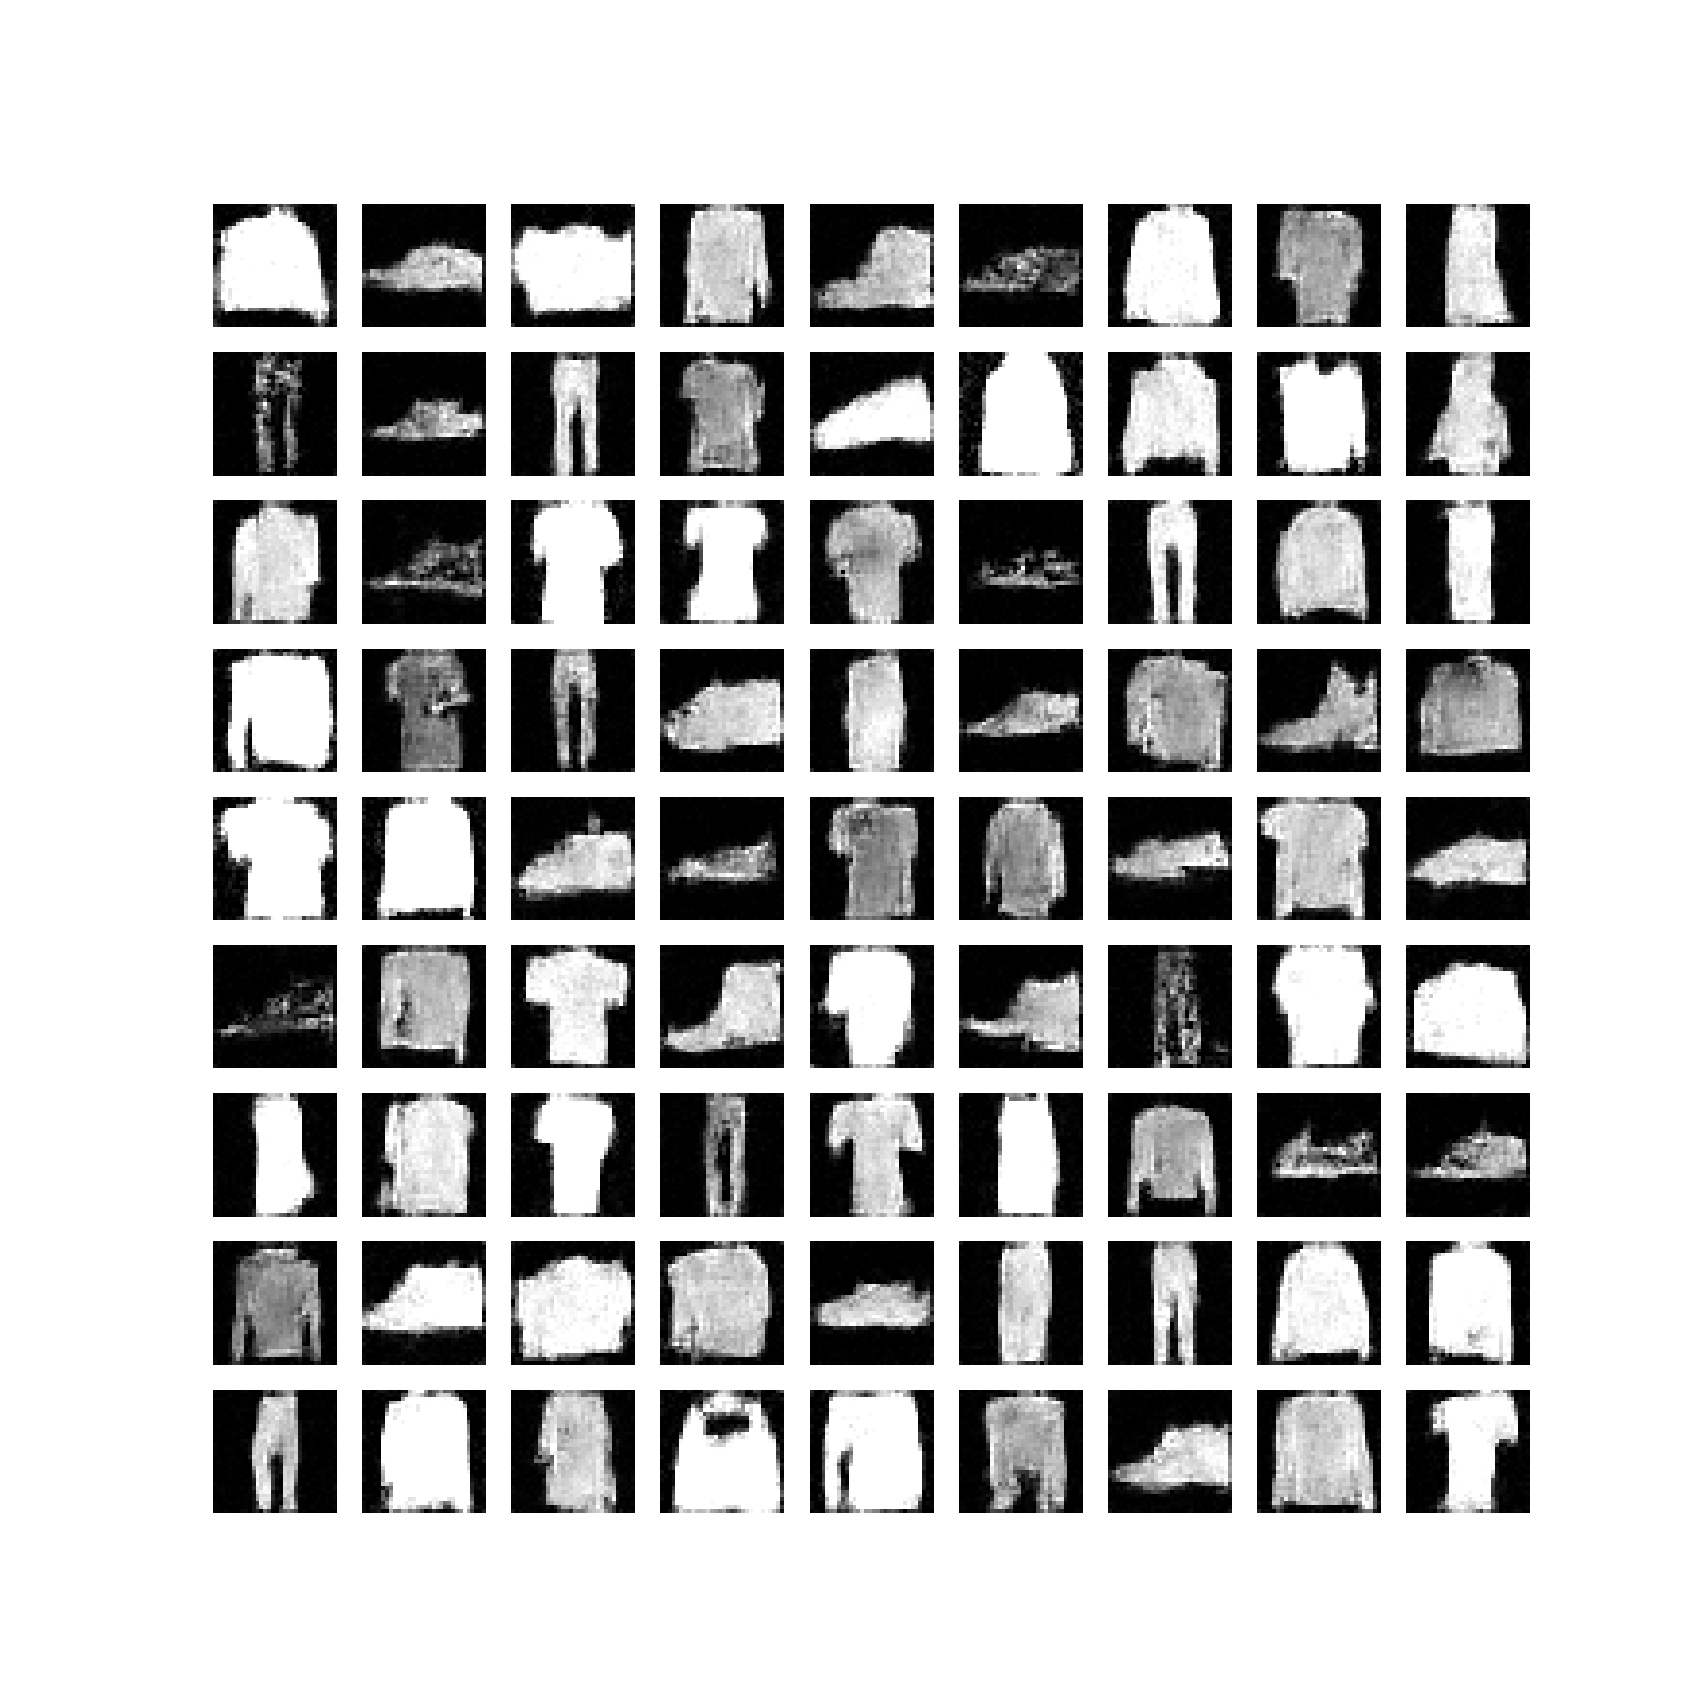

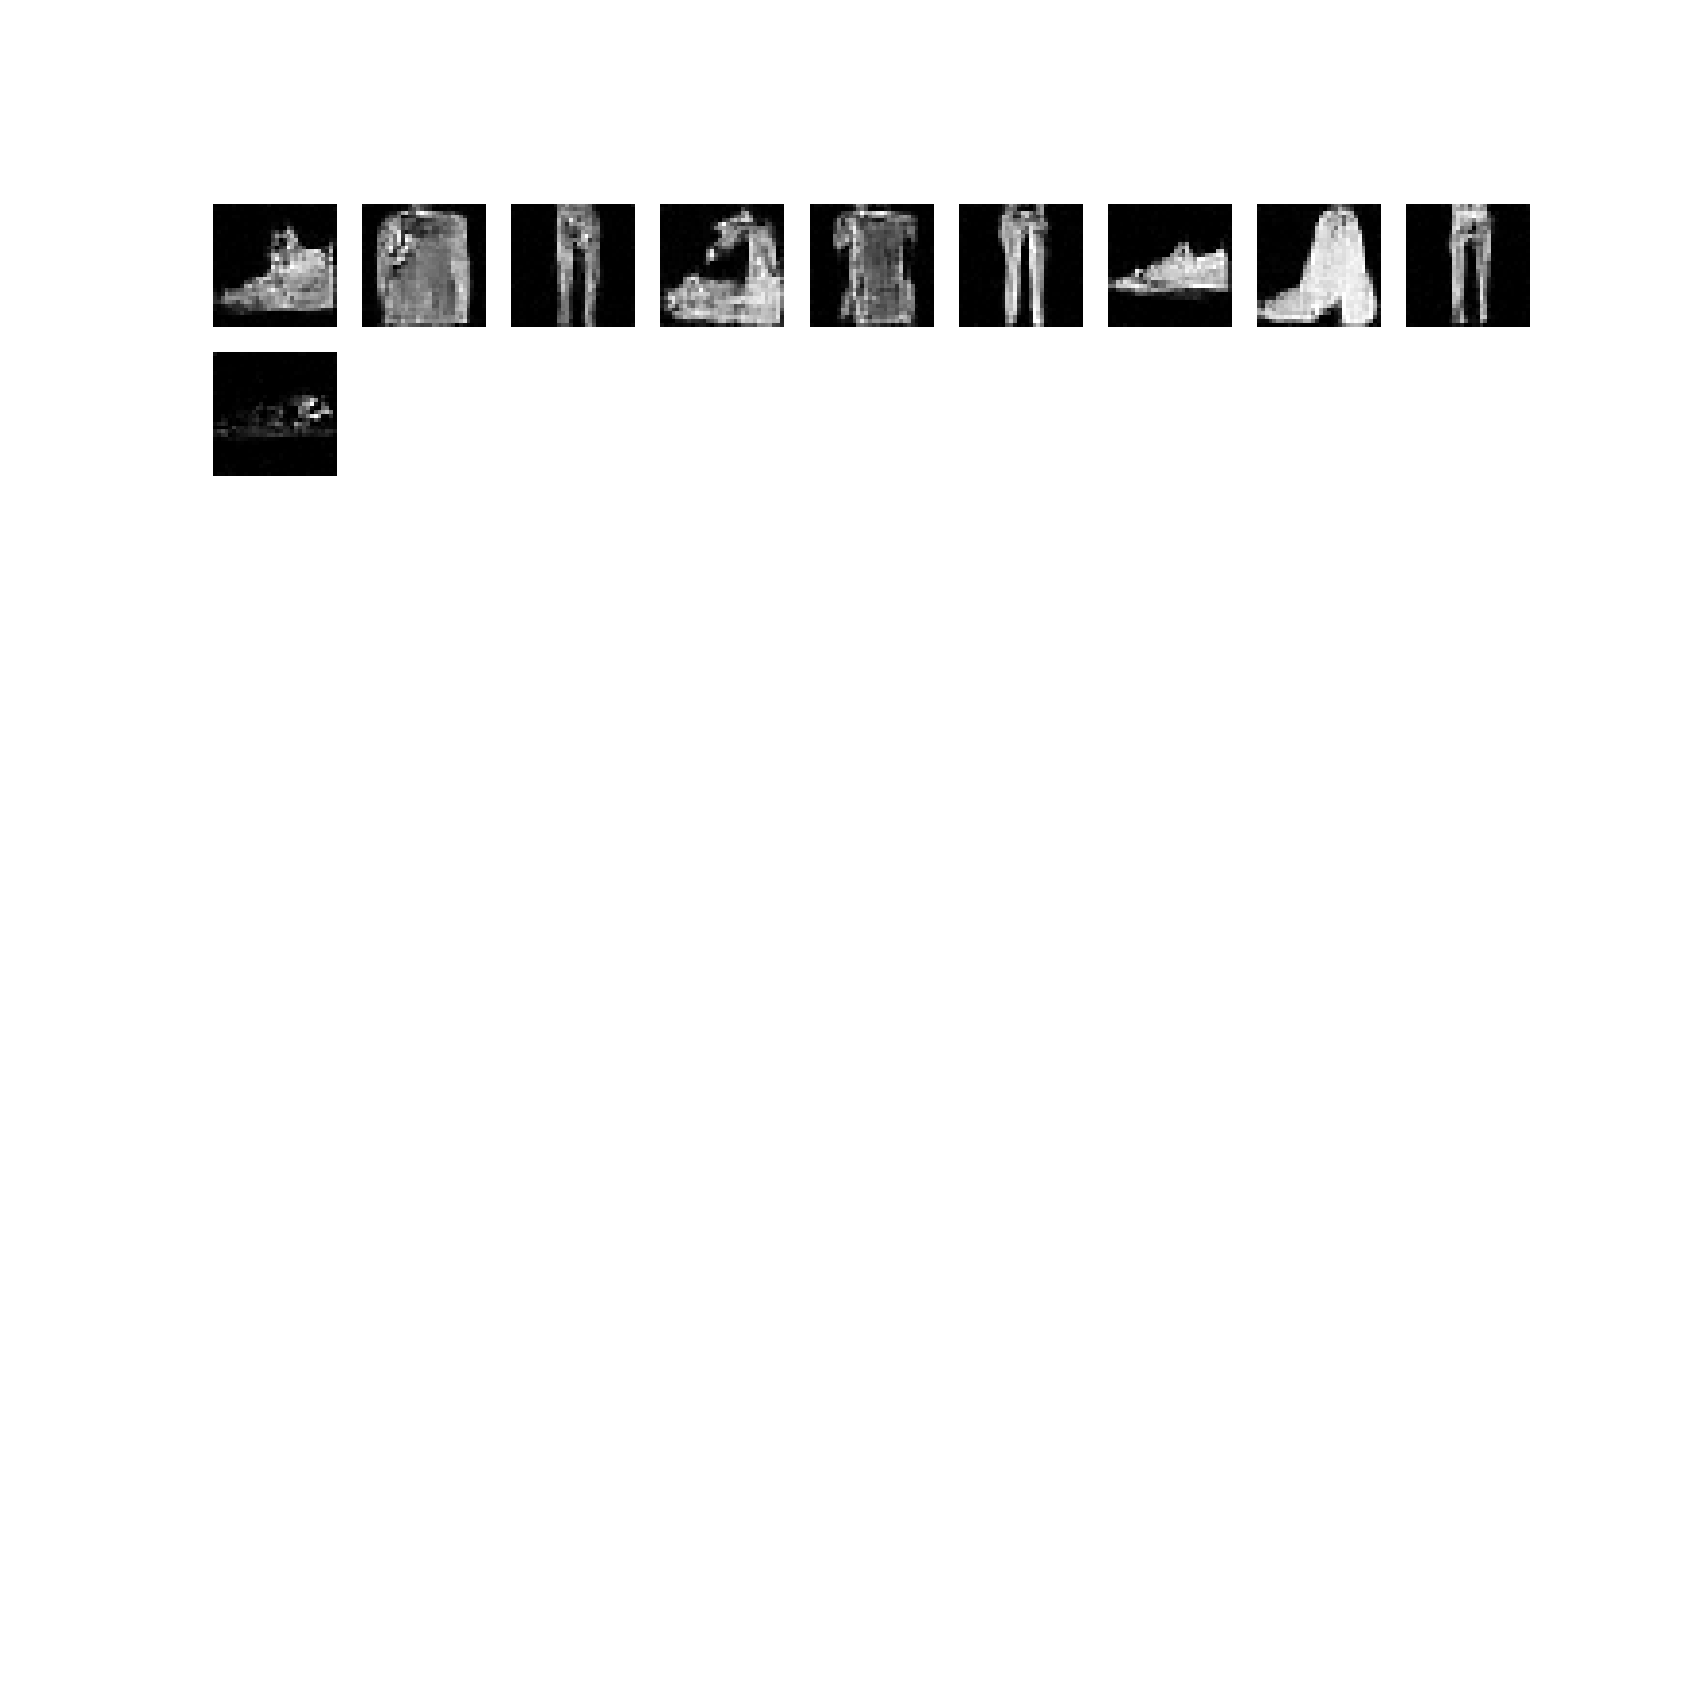